# 1D synthesis

### Using 1D solar model from Allen's Astrophysical Quantities

100/100 - done                           

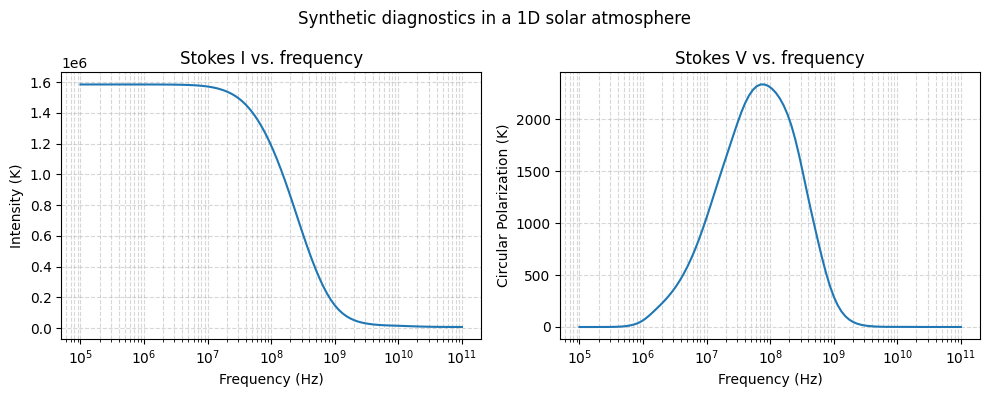

In [ ]:
import numpy as np
from io import StringIO
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import njit
import pysolrad
np.seterr(divide='ignore', invalid='ignore')

with open('./models/Allen-Solar-Atmosphere.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text_fixed = text.replace('–', '-')
data = np.loadtxt(StringIO(text_fixed), skiprows=1)[:, 1:]
data = data[data[:, 0] >= 0] # filter by positive heights
height = data[:,0]*1000.*100. # heights
temp = data[:,2] # temperatures
ne = data[:,8]
pg = data[:, 4] # gas pressures
ptot = data[:, 5]  # total pressures
pmag = np.clip(ptot - pg, 0, None)  # magnetic pressures
blos = np.sqrt(8 * np.pi * pmag) # magnetic field along LOS
n_points = height.size * 10
heights = np.linspace(height.min(), height.max(), n_points)

tempInt = interp1d(height, temp, kind='linear', fill_value='extrapolate')
neInt = interp1d(height, ne, kind='linear', fill_value='extrapolate')
blosInt = interp1d(height, blos, kind='linear', fill_value='extrapolate')
temp = tempInt(heights)
ne = neInt(heights)
blos = blosInt(heights)
dl = np.abs(np.diff(heights)) # difference in heights

vs = np.logspace(5, 11, 100) # frequencies to sample
rays = pysolrad.RayCollection(temp[:-1], blos[:-1], blos[:-1], ne[:-1], dl, False) # dl uses diffs between quantities, we have 1 less data point
images = pysolrad.synthesize_range(rays, vs, dogyro=False)
fields ={'I': ('Stokes I vs. frequency', 'Intensity (K)'), 'V': ('Stokes V vs. frequency', 'Circular Polarization (K)')}
plt.figure(figsize=(10, 4))
for i, field in enumerate(fields, 1):
    vals = [getattr(img, field) for img in images]
    plt.subplot(1, 2, i)
    plt.plot(vs, vals)
    plt.title(fields[field][0])
    plt.ylabel(fields[field][1])
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
plt.suptitle('Synthetic diagnostics in a 1D solar atmosphere')
plt.tight_layout()
plt.show()

### 1D magnetic field inversion

$P=n\frac{2.8\times 10^6}{v}B_{\text{los}}$ where spectral index $n\equiv -\frac{\partial{\log T_b}}{\partial{\log v}}$ and $P=\frac{V}{I}$

from Chapter 6 of [Solar and Space Weather Radio Physics](https://drive.google.com/file/d/1nPEj6RIKA_eOtnwODCnCgedhT0LWunM2/view)

c:\Users\cgraham\Desktop\pysolrad\pysolrad.py:644: RuntimeWarning: divide by zero encountered in divide
  inverted_blos = (P*vs_comp)/(2.8e6*spectral_idx)


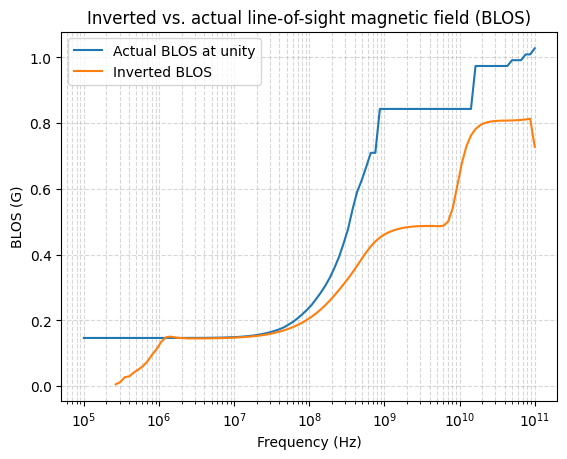

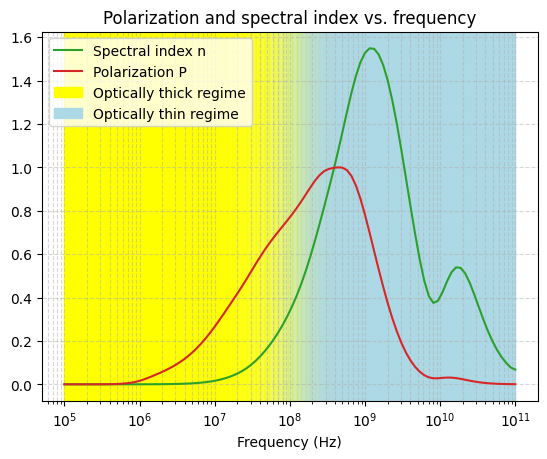

In [2]:
inverted_blos = pysolrad.invert_blos(images)
blos_at_unity = pysolrad.get_quantity_at_unity(rays, images, 'blos')
spectral_idx = pysolrad.get_spectral_idx(images)
P = images.V/images.I

plt.figure()
plt.plot(vs, blos_at_unity, label='Actual BLOS at unity')
plt.plot(vs, inverted_blos, label='Inverted BLOS')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('BLOS (G)')
plt.legend()
plt.title('Inverted vs. actual line-of-sight magnetic field (BLOS)')
plt.show()

plt.figure()
plt.plot(vs, spectral_idx, color='tab:green', label='Spectral index n')
P_normalized = (P - P.min()) / (P.max() - P.min())
plt.plot(vs, P_normalized, color='tab:red', label='Polarization P')
unity = np.array([img.unity for img in images])
unity_normalized = (unity - unity.min()) / (unity.max() - unity.min())
label_done = False
for i in range(len(vs) - 1):
    plt.axvspan(vs[i], vs[i+1], color='lightblue', alpha=unity_normalized[i], label='Optically thin regime' if i == len(vs) - 2 else None)
    plt.axvspan(vs[i], vs[i+1], color='yellow', alpha=1-unity_normalized[i], label='Optically thick regime' if i == 0 else None)
# plt.plot(vs, unity_normalized)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.title('Polarization and spectral index vs. frequency')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.xscale('log')
plt.show()